In [1]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
kernel = 3
hidden = 32
sigma_min = 0.05
sigma_max = 0.2
model_name = 'LPN_cond'

In [4]:
data_dir = f'../savings/{model_name.lower()}_mrs_h_{hidden}_k_{kernel}_n_({sigma_min}_{sigma_max})/denoise/{sigma_min}/'
x_noisy = np.load(f'{data_dir}/x_noisy.npy')
y_LPN = np.load(f'{data_dir}/y_{model_name}.npy')
y_wv = np.load(f'{data_dir}/y_wv.npy')
gt = np.load(f'{data_dir}/../gt.npy')
print(gt.shape)

(30, 512)


In [5]:
ppm_min = 0.578848480483455
ppm_max = 4.49271535465395
num_points = 512
x_axis = np.linspace(ppm_min, ppm_max, num_points)
x_range_indices = slice(0, 512)
x_range_values = x_axis[x_range_indices]

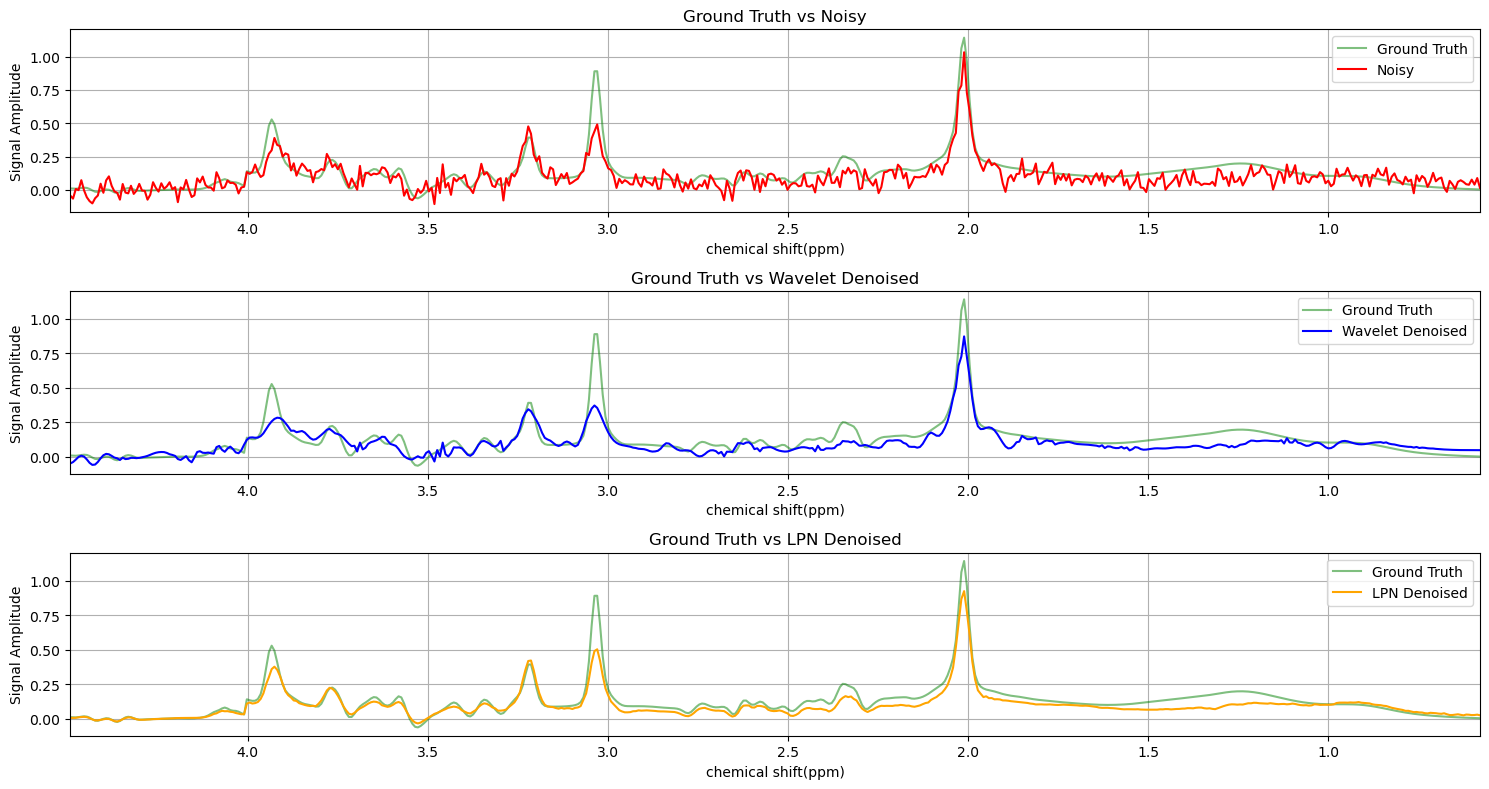

In [6]:
sample_index = 0  # Change as needed

fig, axs = plt.subplots(3, 1, figsize=(15, 8))

# First row: GT and noisy
axs[0].plot(x_range_values, gt[sample_index,x_range_indices], label='Ground Truth', color='green', alpha = 0.5)
axs[0].plot(x_range_values, x_noisy[sample_index,x_range_indices], label='Noisy', color='red')
axs[0].set_title('Ground Truth vs Noisy')
axs[0].set_ylabel('Signal Amplitude')
axs[0].set_xlabel('chemical shift(ppm)')
axs[0].set_xlim(x_range_values[0], x_range_values[-1])
# axs[0].axvline(x=np.linspace(ppm_min, ppm_max, num_points)[220], color='navy', linestyle='--')
# axs[0].axvline(x=np.linspace(ppm_min, ppm_max, num_points)[270], color='navy', linestyle='--')
axs[0].invert_xaxis()
axs[0].legend()
axs[0].grid()

# Second row: GT and wavelet denoised
axs[1].plot(x_range_values, gt[sample_index,x_range_indices], label='Ground Truth', color='green', alpha = 0.5)
axs[1].plot(x_range_values, y_wv[sample_index,x_range_indices], label='Wavelet Denoised', color='blue')
axs[1].set_title('Ground Truth vs Wavelet Denoised')
axs[1].set_ylabel('Signal Amplitude')
axs[1].set_xlabel('chemical shift(ppm)')
axs[1].set_xlim(x_range_values[0], x_range_values[-1])
# axs[1].axvline(x=np.linspace(ppm_min, ppm_max, num_points)[220], color='navy', linestyle='--')
# axs[1].axvline(x=np.linspace(ppm_min, ppm_max, num_points)[270], color='navy', linestyle='--')
axs[1].invert_xaxis()
axs[1].legend()
axs[1].grid()

# Third row: GT and LPN denoised
axs[2].plot(x_range_values, gt[sample_index,x_range_indices], label='Ground Truth', color='green', alpha = 0.5)
axs[2].plot(x_range_values, y_LPN[sample_index,x_range_indices], label='LPN Denoised', color='orange')
axs[2].set_title('Ground Truth vs LPN Denoised')
axs[2].set_ylabel('Signal Amplitude')
axs[2].set_xlabel('chemical shift(ppm)')
axs[2].set_xlim(x_range_values[0], x_range_values[-1])
# axs[2].axvline(x=np.linspace(ppm_min, ppm_max, num_points)[220], color='navy', linestyle='--')
# axs[2].axvline(x=np.linspace(ppm_min, ppm_max, num_points)[270], color='navy', linestyle='--')
axs[2].invert_xaxis()
axs[2].legend()
axs[2].grid()

# Adjust layout for subplots
plt.tight_layout()
plt.show()

In [7]:
sigma_to_psnr = {
    '0.05':27,
    '0.1':22,
    '0.15':20,
    '0.2':18
}

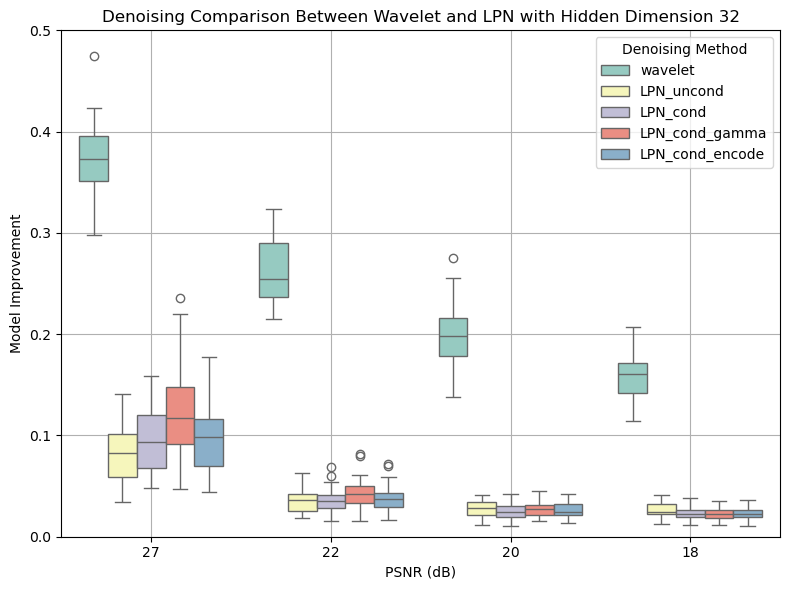

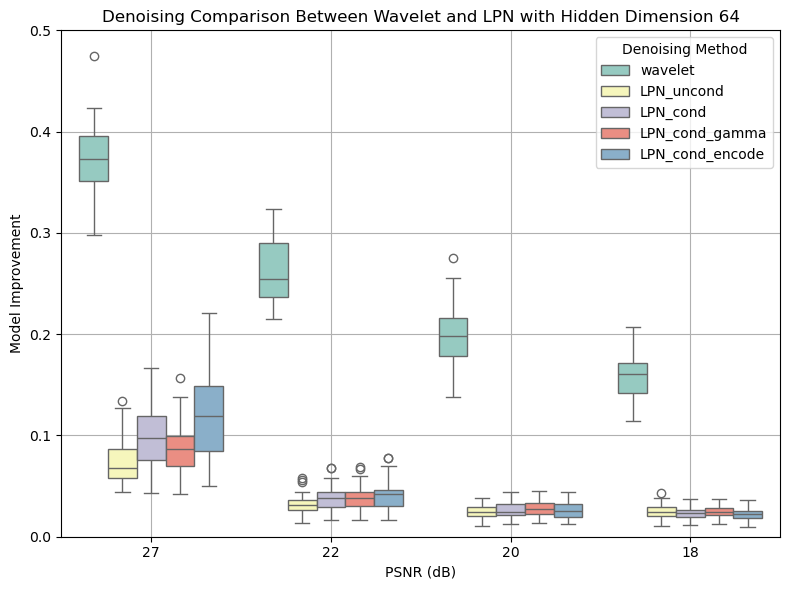

In [8]:
for hidden in [32, 64]:
    lpn_uncond = pd.read_csv(f'../savings/lpn_mrs_h_{hidden}_k_3_n_0.1/denoise/LPN_denoise.csv')
    lpn_cond = pd.read_csv(f'../savings/lpn_cond_mrs_h_{hidden}_k_3_n_(0.05_0.2)/denoise/LPN_cond_denoise.csv')
    lpn_cond_gamma = pd.read_csv(f'../savings/lpn_cond_mrs_h_{hidden}_k_3_n_(0.05_0.2)_gamma/denoise/LPN_cond_denoise.csv')
    lpn_cond_encode = pd.read_csv(f'../savings/lpn_cond_encode_nn_mrs_h_{hidden}_k_3_n_(0.05_0.2)/denoise/LPN_cond_encode_nn_denoise.csv')
    wv = pd.read_csv(f'../savings/lpn_mrs_h_{hidden}_k_3_n_0.1/denoise/wv_denoise.csv')

    lpn_uncond['method'] = 'LPN_uncond'
    lpn_cond['method'] = 'LPN_cond'
    lpn_cond_gamma['method'] = 'LPN_cond_gamma'
    lpn_cond_encode['method'] = 'LPN_cond_encode'
    wv['method'] = 'wavelet'

    # Combine DataFrames
    combined_df = pd.concat([wv, lpn_uncond, lpn_cond, lpn_cond_gamma, lpn_cond_encode], ignore_index=True)
    melted_df = combined_df.melt(id_vars='method', var_name='perturbation', value_name='Improvement')

    # Map sigma values to PSNR values
    melted_df['psnr'] = melted_df['perturbation'].map(sigma_to_psnr)
    psnr_order = sorted(melted_df['psnr'].dropna().unique(), reverse=True)

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='psnr', y='Improvement', hue='method', data=melted_df, palette='Set3', order=psnr_order)
    
    plt.title(f'Denoising Comparison Between Wavelet and LPN with Hidden Dimension {hidden}')
    plt.xlabel('PSNR (dB)')
    plt.ylabel('Model Improvement')
    plt.ylim((0, 0.5))
    plt.legend(title='Denoising Method')
    plt.grid(True)
    # plt.xticks(rotation=45)
    plt.tight_layout() 
    plt.show()